# ``FCNet`` classification demonstration

## Getting started with this demo

To get started with this demo, please create an environment based on ``requirements-dev.conda.yaml``. See the ``README`` for instructions.

The ``torch_tools.FCNet`` model can be used for classification or regression.

Here we will use it for a classification problem. We need:

* Some data:
    * For this example, we'll classify species of penguins based on certain physical features.
* Some data loading utilities:
    * We need to load the data using a ``Dataset`` and ``DataLoader``.
* A model:
    * We will instantiate the model shortly.
* A loss function.
* An optimiser to fit the model with.

## Classification example


First, we load the penguin datasets, which is conveniently available as a ``pandas.DataFrame``.

In [44]:
from palmerpenguins import load_penguins

all_data = load_penguins()

print(all_data)

       species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0       Adelie  Torgersen            39.1           18.7              181.0   
1       Adelie  Torgersen            39.5           17.4              186.0   
2       Adelie  Torgersen            40.3           18.0              195.0   
3       Adelie  Torgersen             NaN            NaN                NaN   
4       Adelie  Torgersen            36.7           19.3              193.0   
..         ...        ...             ...            ...                ...   
339  Chinstrap      Dream            55.8           19.8              207.0   
340  Chinstrap      Dream            43.5           18.1              202.0   
341  Chinstrap      Dream            49.6           18.2              193.0   
342  Chinstrap      Dream            50.8           19.0              210.0   
343  Chinstrap      Dream            50.2           18.7              198.0   

     body_mass_g     sex  year  
0         3750.0  

We remove any row where data are missing.

In [45]:
where_missing = all_data.isna().any(axis=1)

all_data = all_data.loc[~where_missing].reset_index(drop=True)
print(all_data)

       species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0       Adelie  Torgersen            39.1           18.7              181.0   
1       Adelie  Torgersen            39.5           17.4              186.0   
2       Adelie  Torgersen            40.3           18.0              195.0   
3       Adelie  Torgersen            36.7           19.3              193.0   
4       Adelie  Torgersen            39.3           20.6              190.0   
..         ...        ...             ...            ...                ...   
328  Chinstrap      Dream            55.8           19.8              207.0   
329  Chinstrap      Dream            43.5           18.1              202.0   
330  Chinstrap      Dream            49.6           18.2              193.0   
331  Chinstrap      Dream            50.8           19.0              210.0   
332  Chinstrap      Dream            50.2           18.7              198.0   

     body_mass_g     sex  year  
0         3750.0  

Now let's decide on which features to use for classification.

In [46]:
print(all_data.keys())
print(all_data.species.unique())

Index(['species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex', 'year'],
      dtype='object')
['Adelie' 'Gentoo' 'Chinstrap']


To classify the penguins, we'll use bill length, bill depth, flipper length, body mass and year.

In [47]:
input_keys = [
    "bill_length_mm",
    "bill_depth_mm",
    "flipper_length_mm",
    "body_mass_g",
    "sex",
]

target_keys = ["species"]


all_data = all_data[input_keys + target_keys]

species = ["Adelie", "Chinstrap", "Gentoo"]
all_data.species = all_data.species.apply(lambda x: species.index(x))

# We also make the sex field binary
all_data.sex = (all_data.sex == "female").astype(int)

print(all_data)

     bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  sex  \
0              39.1           18.7              181.0       3750.0    0   
1              39.5           17.4              186.0       3800.0    1   
2              40.3           18.0              195.0       3250.0    1   
3              36.7           19.3              193.0       3450.0    1   
4              39.3           20.6              190.0       3650.0    0   
..              ...            ...                ...          ...  ...   
328            55.8           19.8              207.0       4000.0    0   
329            43.5           18.1              202.0       3400.0    1   
330            49.6           18.2              193.0       3775.0    0   
331            50.8           19.0              210.0       4100.0    0   
332            50.2           18.7              198.0       3775.0    1   

     species  
0          0  
1          0  
2          0  
3          0  
4          0  
..       

Now we obtain training and validation splits

In [48]:
valid_split = all_data.groupby(by=["species", "sex"]).sample(
    n=10,
    random_state=123,
)

train_split = all_data.loc[~all_data.index.isin(valid_split.index)]

The training and validation datasets are pandas ``DataFrame`` objects, holding various physical characteristics of the tumours, along with their classifications.

In [49]:
print(train_split)
print(valid_split)

     bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  sex  \
0              39.1           18.7              181.0       3750.0    0   
1              39.5           17.4              186.0       3800.0    1   
2              40.3           18.0              195.0       3250.0    1   
4              39.3           20.6              190.0       3650.0    0   
5              38.9           17.8              181.0       3625.0    1   
..              ...            ...                ...          ...  ...   
324            45.6           19.4              194.0       3525.0    1   
325            51.9           19.5              206.0       3950.0    0   
327            45.7           17.0              195.0       3650.0    1   
330            49.6           18.2              193.0       3775.0    0   
331            50.8           19.0              210.0       4100.0    0   

     species  
0          0  
1          0  
2          0  
4          0  
5          0  
..       

Now we have downloaded the breast cancer dataset from scikit-learn and split the data into a training and validation set. Conventially, one should split the data into a training, validation and testing set, but since this is only a simple example, with a very small dataset, we only use a training and a validation set.

As a matter of convenience, let's grab a list of the keys for accessing the data and targets separately.

Now, we create ``DataSet`` objects for the training and validation sets.

In [50]:
import torch

torch.manual_seed(123)


from torchvision.transforms import Compose

from torch_tools import DataSet

train_set = DataSet(
    inputs=tuple(train_split[input_keys].to_numpy()),
    targets=tuple(train_split[target_keys].to_numpy()),
    target_tfms=Compose([lambda x: torch.eye(3)[x].squeeze()]),
    input_tfms=Compose([torch.from_numpy]),
    mixup=True,
)

valid_set = DataSet(
    inputs=tuple(valid_split[input_keys].to_numpy()),
    targets=tuple(valid_split[target_keys].to_numpy()),
    target_tfms=Compose([lambda x: torch.eye(3)[x].squeeze()]),
    input_tfms=Compose([torch.from_numpy]),
)

The ``DataSet`` objects are iterables which yield input–target pairs (as ``torch.Tensor``s):

In [51]:
for input_item, target in valid_set:
    print(input_item.shape, target.shape)

torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Size([5]) torch.Size([3])
torch.Si

While PyTorch ``Dataset``s generally return single input-target pairs, we normally supply data to neural networks in mini-batches. The PyTorch way to achieve this is use a ``DataLoader`` object.

In [52]:
from torch.utils.data import DataLoader

batch_size = 8

train_loader = DataLoader(
    train_set,
    shuffle=True,
    batch_size=batch_size,
    drop_last=True,
)
valid_loader = DataLoader(valid_set, shuffle=False, batch_size=batch_size)

for batch, targets in valid_loader:
    print(batch.shape, targets.shape)

torch.Size([8, 5]) torch.Size([8, 3])
torch.Size([8, 5]) torch.Size([8, 3])
torch.Size([8, 5]) torch.Size([8, 3])
torch.Size([8, 5]) torch.Size([8, 3])
torch.Size([8, 5]) torch.Size([8, 3])
torch.Size([8, 5]) torch.Size([8, 3])
torch.Size([8, 5]) torch.Size([8, 3])
torch.Size([4, 5]) torch.Size([4, 3])


Now we can that each input is a ``Tensor`` of shape ``(10, 5)`` because each input has 5 features and we use a batch size of ten. The targets are simply one-hot-encoded vectors giving the binary classification of each input item.

Before we train the model. we need to decide whether we want to train the model on the GPU or the CPU. PyTorch has a way of managing this:

In [53]:
from torch.cuda import is_available

DEVICE = "cuda" if is_available() else "cpu"
print(DEVICE)

cuda


Now we have the data, we need a model, loss function and optimiser. Let's set these things up:

- For our choice of model, we can use the ``torch_tools.FCNet`` model.
- For the loss function, we choose the (fairly) standard binary-cross-entropy.
  - See PyTorch's [BCELoss docs](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html).
- For our optimiser, we will use the (again fairly standard) Adam optimiser.
  - See PyTorch's [Adam optimiser docs](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).

In [54]:
from torch.nn import BCELoss
from torch.optim import Adam

from torch_tools import FCNet


loss_func = BCELoss(reduction="sum")

model = FCNet(
    in_feats=5,
    out_feats=3,
    hidden_sizes=(32, 16, 8),
    input_dropout=0.1,
    input_bnorm=True,
    hidden_dropout=0.25,
).to(DEVICE)
print(model)


optimiser = Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

FCNet(
  (0): InputBlock(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.1, inplace=False)
  )
  (1): DenseBlock(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): LeakyReLU(negative_slope=0.1)
  )
  (2): DenseBlock(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): LeakyReLU(negative_slope=0.1)
  )
  (3): DenseBlock(
    (0): Linear(in_features=16, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): LeakyReLU(negative_slope=0.1)
  )
  (4): DenseBlock(
    (0): Linear(in_features=8, out_features=3, bias=True)
  )
)


Let's write functions for training and validating single epochs

In [55]:
from torch.nn import Module
from torch import no_grad


def train_one_epoch(
    model: Module,
    loss_func: BCELoss,
    optim: Adam,
    train_loader: DataLoader,
):
    """Train the model for a single epoch.

    Parameters
    ----------
    model : Module
        The model we want to train.
    loss_func : BCELoss
        Binary-cross-entropy loss function.
    optim : Adam
        Adam optimiser.
    train_loader : DataLoader
        Training dataloader.

    Returns
    -------
    mean_loss: float
        Mean loss per batch.
    accuracy : float
        Accuracy over the epoch.

    """
    model.train()
    running_loss = 0.0
    correct = 0
    for batch, targets in train_loader:
        # Move the inputs and targets from the cpu to the gpu.
        batch, targets = batch.float().to(DEVICE), targets.float().to(DEVICE)
        # Zero the gradients.
        optim.zero_grad()
        # Predict using the batch of inputs.
        prediction = model(batch).softmax(dim=1)
        # Compute the loss
        loss = loss_func(prediction, targets)
        # Backpropagate (differentiate the parameters wrt the loss)
        loss.backward()
        # Step the parameters
        optim.step()
        # Record the loss
        running_loss += loss.item()
        # Record the number of correctly classified items
        correct += (
            (prediction.detach().argmax(dim=1) == targets.argmax(dim=1))
            .sum()
            .cpu()
            .item()
        )

    mean_loss = running_loss / len(train_loader.dataset)
    accuracy = correct / len(train_loader.dataset)

    return mean_loss, accuracy


@no_grad()
def validate_one_epoch(
    model: Module,
    loss_func: BCELoss,
    valid_loader: DataLoader,
):
    """Validate single epoch.

    Parameters
    ----------
    model : Module
        The model to validate.
    loss_func : BCELoss
        Binary-cross-entropy loss function.
    valid_loader : DataLoader
        Validation data loader.

    Returns
    -------
    float
        Mean loss per item.
    accuracy : float
        Accuracy over the epoch.

    """
    model.eval()
    running_loss = 0.0
    correct = 0
    for batch, targets in valid_loader:
        # Move the inputs and targets from the cpu to the gpu.
        batch, targets = batch.float().to(DEVICE), targets.float().to(DEVICE)
        # Predict using the batch of inputs
        pred = model(batch).softmax(dim=1)
        # Calculate the loss
        loss = loss_func(pred, targets)
        # Record the number of correctly classified items
        correct += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().cpu().item()
        # Record the loss
        running_loss += loss.item()

    mean_loss = running_loss / len(valid_loader.dataset)
    accuracy = correct / len(valid_loader.dataset)

    return mean_loss, accuracy

Now, we train!

In [56]:
metrics = {
    "train_loss": [],
    "valid_loss": [],
    "train_acc": [],
    "valid_acc": [],
}

for epoch in range(250):
    train_loss, train_acc = train_one_epoch(
        model,
        loss_func,
        optimiser,
        train_loader,
    )
    valid_loss, valid_acc = validate_one_epoch(model, loss_func, valid_loader)

    metrics["train_loss"].append(train_loss)
    metrics["train_acc"].append(train_acc)
    metrics["valid_loss"].append(valid_loss)
    metrics["valid_acc"].append(valid_acc)

Now that the model is trained, we can plot the ``metrics`` dictionary we have populated.

     train_loss  valid_loss  train_acc  valid_acc
0      2.166969    2.167670   0.424908   0.383333
1      2.191075    2.067840   0.417582   0.333333
2      2.107215    2.079085   0.399267   0.383333
3      2.091307    2.012799   0.406593   0.416667
4      2.012917    1.972705   0.472527   0.516667
..          ...         ...        ...        ...
245    0.970985    0.573543   0.838828   0.983333
246    1.066119    0.538644   0.842491   0.983333
247    1.030296    0.588412   0.853480   0.983333
248    1.096516    0.548747   0.813187   0.966667
249    0.995541    0.620299   0.831502   0.983333

[250 rows x 4 columns]


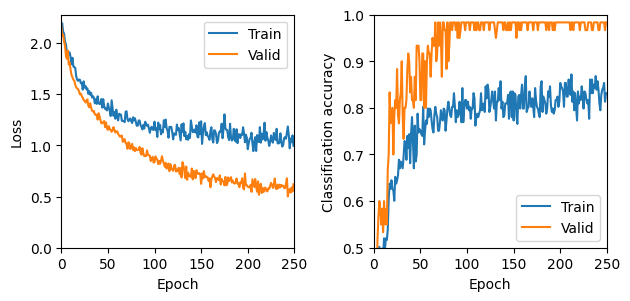

In [57]:
from pandas import DataFrame
import matplotlib.pyplot as plt


print(DataFrame(metrics))


figure, axes = plt.subplots(1, 2)
axes[0].plot(metrics["train_loss"], label="Train")
axes[0].plot(metrics["valid_loss"], label="Valid")


axes[1].plot(metrics["train_acc"], label="Train")
axes[1].plot(metrics["valid_acc"], label="Valid")

axes[0].set_ylim(bottom=0.0)
axes[1].set_ylim(bottom=0.5, top=1.0)

axes[0].set_ylabel("Loss")
axes[1].set_ylabel("Classification accuracy")


for axis in axes.ravel():
    axis.set_xlabel("Epoch")
    axis.set_xlim(left=0.0, right=len(metrics["train_acc"]))
    axis.set_aspect(
        (axis.get_xlim()[1] - axis.get_xlim()[0])
        / (axis.get_ylim()[1] - axis.get_ylim()[0])
    )
    axis.legend()


figure.tight_layout()

plt.show()

With no prior knowledge of this dataset, or the fidelity of the ground truths, this seems like more-than-reasonable performance.